# Занятие 3: Хемоинформатика

### Мазаев Лев, мАДБМ18

In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import RDConfig
from rdkit.Chem.Draw import IPythonConsole 
from rdkit.Chem import Draw
import rdkit.Chem.Lipinski as Lipinksi
from IPython.display import display, Image
import numpy as np
from rdkit import rdBase
rdBase.DisableLog('rdApp.error')

RDKit WARNING: [23:49:28] Enabling RDKit 2019.09.1 jupyter extensions


Нарисуем ибупрофен из SMILES-формулы:

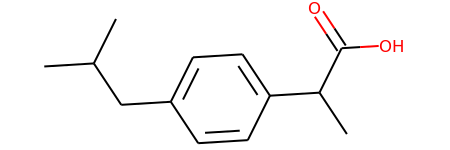

In [2]:
ibu = Chem.MolFromSmiles('CC(C)CC1=CC=C(C=C1)C(C)C(=O)O')
AllChem.Compute2DCoords(ibu)
display(ibu)

Правила 5 Липински:
- количество доноров водородной связи <= 5
- количество акцепторов водородной связи <= 10
- молекулярная масса не более 500 дальтон
- липофильность менее 5

In [3]:
print(Lipinksi.NumHDonors(ibu))  # количество доноров водородной связи
print(Lipinksi.NumHAcceptors(ibu))  # количество акцепторов водородной связи
print(Lipinksi.rdMolDescriptors.CalcExactMolWt(ibu))  # молекулярная масса
print(Lipinksi.rdMolDescriptors.CalcCrippenDescriptors(ibu)[0])  # липофильность

1
1
206.130679816
3.073200000000001


Заменим изопропил на этин в формуле ибупрофена:

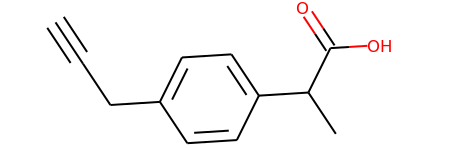

In [4]:
ibumod = Chem.MolFromSmiles('C#CCC1=CC=C(C=C1)C(C)C(=O)O')
AllChem.Compute2DCoords(ibumod)
display(ibumod)

Тогда в результате реакции азид-алкинового циклоприсоединения должно получаться следующее:

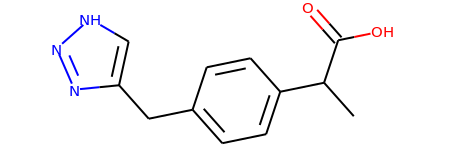

In [5]:
template_smiles = 'N2N=NC(=C2)CC1=CC=C(C=C1)C(C)C(=O)O'
template = Chem.MolFromSmiles(template_smiles)
AllChem.Compute2DCoords(template)
display(template)

Далее, нам необходимо все радикалы, содержащие в себе азид и скачать их SMILES нотации. Сам азид выглядит следующим образом:

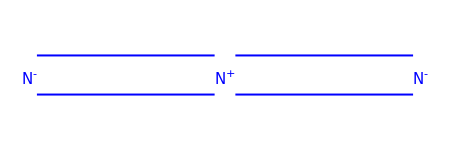

In [6]:
azide = Chem.MolFromSmiles('[N-]=[N+]=[N-]')
display(azide)

Для поиска таких радикалов сформируем SMARTS-запрос: \[N\]=\[N;!R\]=\[N\], где !R - запрещает цикл, иначе это будет уже не азид. Отправим этот запрос в базу PubChem. Видим 162287 результатов:

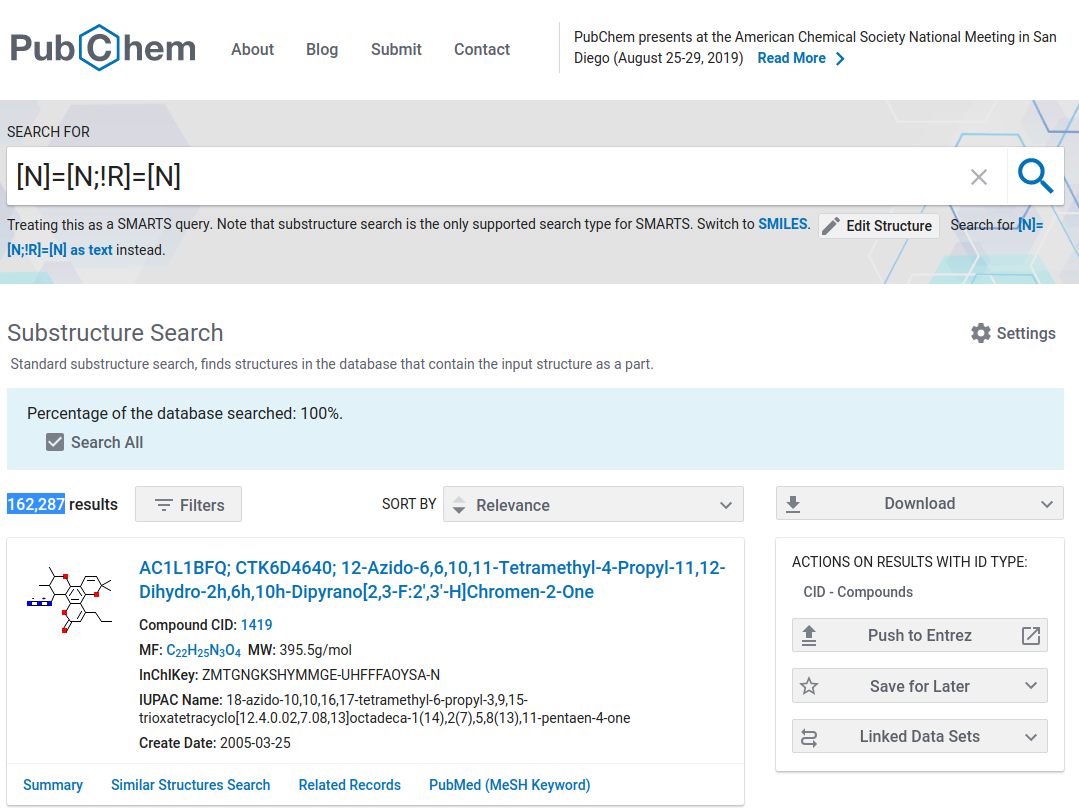

In [7]:
Image('scr1.png')

Жмём Push to Entrez, затем Structure Download, там выбираем SMILES и скачиваем файл.

Кроме того, существует другой вариант азида:

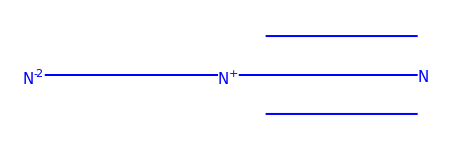

In [8]:
azide1 = azide
azide2 = Chem.MolFromSmiles('[N]#[N+][N-2]')
display(azide2)

Поищем и этот вариант в базах, сформировав следующий SMARTS: \[N\]#\[N;!R\]\[N\].

Всего нашлось 1182 результатов. Объединим результаты поиска. Оказывается в SMILES-записях встречается разное обозначение азидов, это нужно учесть в дальнейшем при замене азида на соединение с ибупрофеном. Вероятно, некоторые из них азиду и не соответствуют.

In [9]:
%%bash
echo 'Число записей в первом файле:' `wc -l file1.txt`
echo 'Число записей во втором файле:' `wc -l file2.txt`
echo 'Оказывается не все молекулы с такой записью азида N=[N+]=[N-]:' `grep 'N=\[N+\]=\[N-\]' file1.txt | wc -l` 
echo 'Ещё встречается запись N=[N+]=N:' `grep 'N=\[N+\]=N' file1.txt | wc -l`
echo 'Во втором файле тоже не все с принятой записью N[N+]#N:' `grep 'N\[N+\]#N' file2.txt | wc -l` 
cat file1.txt file2.txt > file.txt

Число записей в первом файле: 162275 file1.txt
Число записей во втором файле: 1182 file2.txt
Оказывается не все молекулы с такой записью азида N=[N+]=[N-]: 158640
Ещё встречается запись N=[N+]=N: 2560
Во втором файле тоже не все с принятой записью N[N+]#N: 697


In [10]:
strings=np.genfromtxt('file.txt', dtype=np.str)

smiles = []
for line in strings:
    if len(line[1]) <= 40 and not '.' in line[1]:
        smiles.append(line[1])
        
print('Количество оставшихся молекул: ', len(smiles))

Количество оставшихся молекул:  45350


Посмотрим как выглядят некоторые радикалы с азидом:

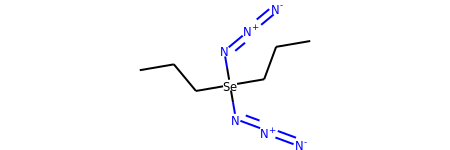

CCC[Se](CCC)(N=[N+]=[N-])N=[N+]=[N-]


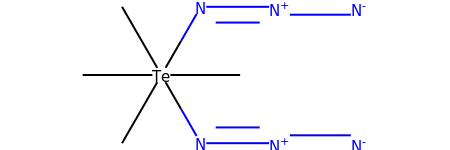

C[Te](C)(C)(C)(N=[N+]=[N-])N=[N+]=[N-]


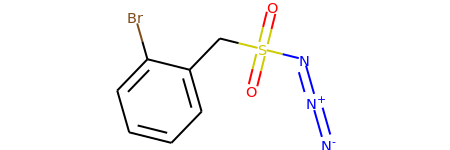

C1=CC=C(C(=C1)CS(=O)(=O)N=[N+]=[N-])Br


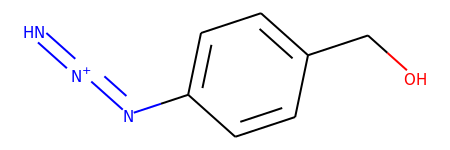

C1=CC(=CC=C1CO)N=[N+]=N


In [11]:
def mol_display(x):
    display(Chem.MolFromSmiles(x))

for n in (0, 5, 55, 124):
    mol_display(smiles[n])
    print(smiles[n])

Видно, что некоторые молекулы допускают присоединение другого радикала в реакции несколькими способами. Подсчитаем в скольких молекулах содержится азид в разных записях.

In [12]:
c1, c2, c3 = 0, 0, 0
for x in smiles:
    if 'N=[N+]=[N-]' in x:
        c1 += 1
    if '[N-]=[N+]=N' in x:
        c2 += 1
    if '#' in x:
        c3 += 1        
print(f'Число молекул с азидом N=[N+]=[N-]: {c1}',
      f'Число молекул с развернутой записью азида: {c2}',
      f'Число молекул, где есть тройная связь: {c3}',
     sep='\n')

Число молекул с азидом N=[N+]=[N-]: 38946
Число молекул с развернутой записью азида: 122
Число молекул, где есть тройная связь: 0


Как видим, азидом с тройной связью можно пренебречь, радикалов с развернутым азидом тоже немного. Остальные неподсчитанные вещества приходятся на какой-то другой тип записи. Будем выполнять поиск подходящих радикалов только среди тех, азид которых записан как N=\[N+\]=\[N-\]. Кроме того, будем учитывать, что некоторые молекулы содержат несколько мест осуществления реакций.

In [13]:
candidates = []

def pattern_start_end(p, s):
    '''
    Функция возвращает все вхождения подстроки в строку в виде
    стартовой и конечной позиций
    '''
    n, m = len(s), len(p)
    a = []
    for i in range(n - m + 1):
        if p == s[i:i+m]:
            a.append((i, i + m))
    return a
    

for x in smiles:
    res = pattern_start_end('N=[N+]=[N-]', x)
    if res:
        for start, end in res:
            s = x[:start] + template_smiles + x[end:]
            candidates.append(s)
            
print('Число молекул-кандидатов:', len(candidates))

Число молекул-кандидатов: 39680


In [14]:
def satisfies_5_lipinski(x):
    return all([
        Lipinksi.NumHDonors(x) <= 5,  # количество доноров водородной связи
        Lipinksi.NumHAcceptors(x) <= 10,  # количество акцепторов водородной связи
        Lipinksi.rdMolDescriptors.CalcExactMolWt(x) <= 500,  # молекулярная масса
        Lipinksi.rdMolDescriptors.CalcCrippenDescriptors(x)[0] < 5,  # липофильность
    ])

result = []

for c in candidates:
    try:
        mol = Chem.MolFromSmiles(c)
        if satisfies_5_lipinski(mol):
            result.append(mol)
    except:
        pass

In [15]:
print('Осталось молекул после фильтрации:', len(result))

Осталось молекул после фильтрации: 37476


Отобразим какие-нибудь из молекул:

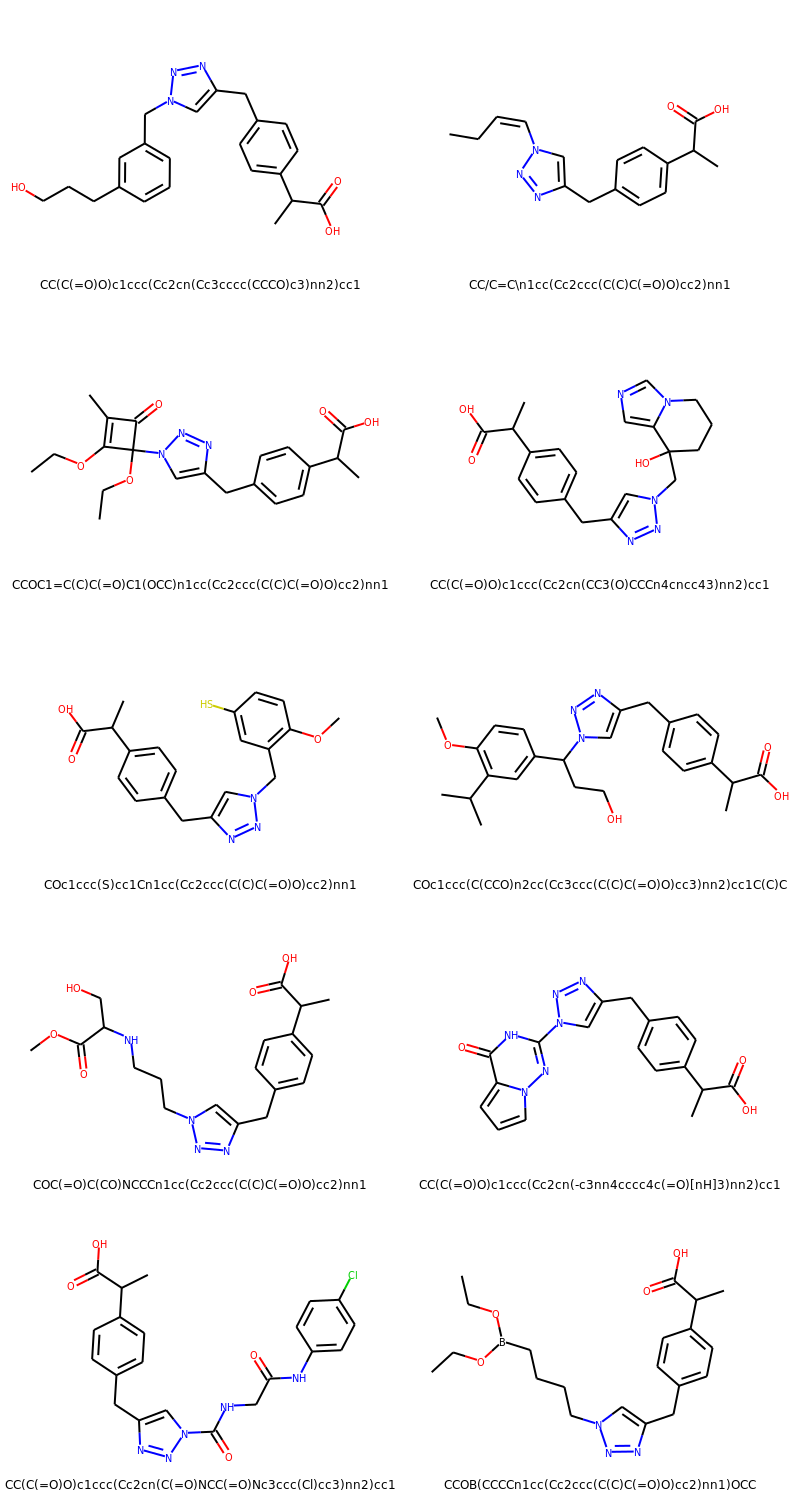

In [16]:
mols = np.random.choice(result, size=10, replace=False)
legends = [AllChem.MolToSmiles(mol) for mol in mols]
Draw.MolsToGridImage(mols, molsPerRow=2, subImgSize=(400, 300), legends=legends)

Отобразим 3D-структуры:

In [17]:
import nglview as nv
from nglview.widget import VBox
from IPython.display import IFrame, HTML

_ColormakerRegistry()

In [18]:
mols = np.random.choice(result, size=4, replace=False)
legends = [AllChem.MolToSmiles(mol) for mol in mols]
models = []
for m2d in mols:
    m3d = Chem.AddHs(m2d)
    AllChem.EmbedMolecule(m3d)
    AllChem.MMFFOptimizeMolecule(m3d, maxIters=500, nonBondedThresh=200)
    models.append(nv.show_rdkit(m3d))
VBox(models)

Полученные модели отображаются в самом ноутбуке, но не отображаются в его HTML-версии. Сохраним виджет с моделям как отдельный HTML-файл:

In [19]:
nv.write_html('view.html', models)

Теперь встроим этот файл обратно в ноутбук. Таким образом, получаем два раза один и тот же виджет, но это работает в HTML-версии ноутбука, причем без необходимости держать `view.html` в одной папке с HTML.

In [20]:
HTML('view.html')